In [1]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import measurement_analysis as ma
import statsmodels.api as sm
from scipy.signal import find_peaks
import wrangling
import utility
import tensorflow as tf
import keras

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [13]:
flow_data_DRU, level_data_DRU = lf.get_measurements("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150/RG8150")

In [14]:
flow_data = wrangling.clean_mes_data(flow_data_DRU)
level_data = wrangling.clean_mes_data(level_data_DRU)
flow_data, level_data = wrangling.merge_flow_level(flow_data, level_data)

flow_data["Value"] = flow_data["Value"].fillna(0)
flow_data["DataQuality"] = flow_data["DataQuality"].fillna(0)

In [15]:
def flow_by_hour(df):
    flow_data = df.copy()
    
    # Generate necessary columns
    flow_data["TimeSpan"] = flow_data["TimeStamp"].diff(1).apply(lambda i: i.seconds).fillna(5)
    flow_data["TimeHour"] = flow_data["TimeStamp"].apply(lambda i: i.replace(minute=0, second=0))
    flow_data["Flow"] = flow_data["Value"] / 3600 * flow_data["TimeSpan"]
    
    flow_data = flow_data.groupby("TimeHour").aggregate({"Flow": np.sum, "DataQuality": np.mean})
    dt_range = pd.date_range(flow_data.index[0].floor('h'), flow_data.index[-1].floor('h'), freq='h')
    flow_data = flow_data.reindex(dt_range)
    flow_data["Flow"] = flow_data["Flow"].fillna(0)
    flow_data["DataQuality"] = flow_data["DataQuality"].fillna(0)
    
    return flow_data.reset_index(drop=False).rename(columns={"index": "TimeHour"})

In [16]:
x = flow_by_hour(flow_data)

In [ ]:
class predictor:
    def __init__(self, data):
        NL_holidays = [i[0] for i in holidays.Netherlands(years = [2018, 2019]).items()]
        
        hour_dummies = pd.get_dummies(data["TimeHour"].apply(lambda i: i.hour), prefix="hour")
        month_dummies = pd.get_dummies(data["TimeHour"].apply(lambda i: i.month), prefix="month")
        
        is_holiday = data["TimeHour"].apply(lambda i: i.date() in NL_holidays).astype(int)
        
        self.y = data["Flow"]
        self.X = pd.concat([hour_dummies, month_dummies, is_holiday], axis=1)
        self.X["Constant"] = 1

In [2]:
rain_prediction = lf.get_rain_prediction("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_grid_prediction/knmi.harmonie_2018-01-01_2019-08-29",
                                         reduce_grid=True)

In [17]:
shared_indices = np.intersect1d(rain_prediction[0]["start"].values, x["TimeHour"].values)
rp_indices = rain_prediction[0]["start"].reset_index(drop=False).set_index("start").reindex(shared_indices).values.flatten()

In [31]:
y = x.set_index("TimeHour").reindex(shared_indices)["Flow"].values

In [29]:
X = rain_prediction[1][rp_indices]

In [201]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, GlobalMaxPooling2D, Conv1D, Input, GlobalAveragePooling1D, Lambda
from keras.layers import Bidirectional, AveragePooling1D, GaussianNoise, Concatenate, SeparableConv2D
from keras.layers import concatenate, MaxPooling2D, AveragePooling2D, GlobalAveragePooling3D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers.advanced_activations import LeakyReLU
import keras
from keras.models import Model
from keras import regularizers
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MeanShift, KMeans
from keras.layers import DepthwiseConv2D
from keras import optimizers
from keras.layers import Layer, Reshape
import keras.backend as K
from keras.constraints import maxnorm, nonneg

In [102]:
from keras.layers import Lambda
import scipy
sum_dim1 = Lambda(lambda xin: K.mean(xin, axis=0), output_shape=(None,1))

In [217]:
class ConstMultiplierLayer(Layer):
    def __init__(self, **kwargs):
        super(ConstMultiplierLayer, self).__init__(**kwargs)

    def build(self, input_shape, regularizer=None):
        self.k = self.add_weight(
            name='k',
            shape=(input_shape[1],),
            regularizer=regularizer,
            initializer='zeros',
            dtype='float32',
            trainable=True,
            constraint=nonneg()
        )
        super(ConstMultiplierLayer, self).build(input_shape)

    def call(self, x):
        return K.tf.multiply(self.k, x)

    def compute_output_shape(self, input_shape):
        return input_shape

    
class AvgLayer(Layer):
    def __init__(self, **kwargs):
        super(AvgLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AvgLayer, self).build(input_shape)

    def call(self, x):
        return K.mean(x)

    def compute_output_shape(self, input_shape):
        return (None,1)
    

class SumLayer(Layer):
    def __init__(self, **kwargs):
        super(SumLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SumLayer, self).build(input_shape)

    def call(self, x):
        return K.sum(x)

    def compute_output_shape(self, input_shape):
        return (None,1)


def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [221]:
input_1 = Input(shape = (X.shape[1], X.shape[2]))

#out = Conv1D(32, kernel_size=5, strides=2)(input_1)

# Multiply all values by smth
out = Flatten()(input_1)
out = ConstMultiplierLayer()(out)
out = Reshape(target_shape=(X.shape[1], X.shape[2], 1))(out)

# Gaussian Smoothing
kernel_size = 5
in_channels = 1  # the number of input channels
kernel_weights = matlab_style_gauss2D(shape=(kernel_size, kernel_size), sigma = 0.5)
kernel_weights = np.expand_dims(kernel_weights, axis=-1)
kernel_weights = np.repeat(kernel_weights, in_channels, axis=-1) # apply the same filter on all the input channels
kernel_weights = np.expand_dims(kernel_weights, axis=-1)

#print(kernel_weights)

out = Conv2D(filters = 1, kernel_size=(kernel_size, kernel_size), use_bias=False, padding="same")(out)

out = Flatten()(out)

# TAKE AVG OF ALL VALUES 
out = SumLayer()(out)


model.layers[4].set_weights([kernel_weights])
model.layers[4].trainable = False

model = Model(input_1, out)
model.compile(optimizer = optimizers.Adam(lr=0.001), loss='mean_squared_error')

for i in model.layers:
    print(i.output_shape)

(None, 105, 123)
(None, 12915)
(None, 12915)
(None, 105, 123, 1)
(None, 105, 123, 1)
(None, 12915)
(None, 1)


In [222]:
model.fit(X, y, validation_split=0.1, epochs=5, batch_size=1024, shuffle=True)

Train on 13089 samples, validate on 1455 samples
Epoch 1/5
13089/13089 [==============================] - 67s 5ms/step - loss: 1307280464.7273 - val_loss: 37127.5742
Epoch 2/5
13089/13089 [==============================] - 63s 5ms/step - loss: 48663712.7686 - val_loss: 41860.7620
Epoch 3/5
13089/13089 [==============================] - 61s 5ms/step - loss: 13367637.8162 - val_loss: 40157.3815
Epoch 4/5
13089/13089 [==============================] - 58s 4ms/step - loss: 37173829.0081 - val_loss: 38055.0913
Epoch 5/5
13089/13089 [==============================] - 58s 4ms/step - loss: 27758002.5219 - val_loss: 40117.3126


In [223]:
weights = model.layers[2].get_weights()[0].flatten().reshape(X.shape[1], X.shape[2])

(-0.5, 122.5, 104.5, -0.5)

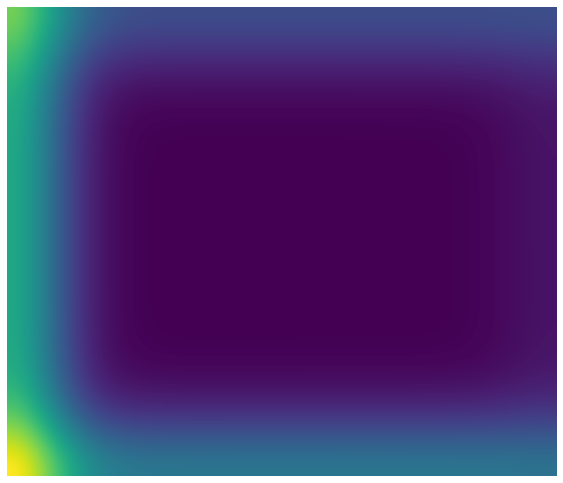

In [224]:
fig, ax = plt.subplots(figsize = (6.56 * 1.5, 10.15 * 1.5))

ax.imshow(scipy.ndimage.filters.gaussian_filter(weights, sigma=10), interpolation="bicubic")   # Interpolation anti-aliases the image


plt.axis('off')

In [214]:
min(weights.flatten())

-0.0

In [ ]:
class ConstMultiplierLayer(Layer):
    def __init__(self, **kwargs):
        super(ConstMultiplierLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.k = self.add_weight(
            name='k',
            shape=(input_shape[1],),
            regularizer=regularizers.l2(0.01),
            initializer='zeros',
            dtype='float32',
            trainable=True,
        )
        super(ConstMultiplierLayer, self).build(input_shape)

    def call(self, x):
        return K.tf.multiply(K.tf.add(self.k, 1), x)

    def compute_output_shape(self, input_shape):
        return input_shape

def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h



input_layer_1 = Input(shape = (x_data.shape[1], x_data.shape[2], x_data.shape[3]))

out = Flatten()(input_layer_1)
out = ConstMultiplierLayer()(out)
out = Reshape(target_shape=(101,101,3))(out)

kernel_weights = matlab_style_gauss2D(shape=(9, 9), sigma=5)

in_channels = 3  # the number of input channels
kernel_weights = np.expand_dims(kernel_weights, axis=-1)
kernel_weights = np.repeat(kernel_weights, in_channels, axis=-1) # apply the same filter on all the input channels
kernel_weights = np.expand_dims(kernel_weights, axis=-1)

out = DepthwiseConv2D(kernel_size, use_bias=False, padding="same")(out)

out = Flatten()(out)

out = Dense(1, activation="linear", kernel_regularizer=regularizers.l2(10))(out)

model = Model([input_layer_1, weight_input], out)

model.layers[4].set_weights([kernel_weights])
model.layers[4].trainable = False
